In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/EVA3/EVA3-Assignment7')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


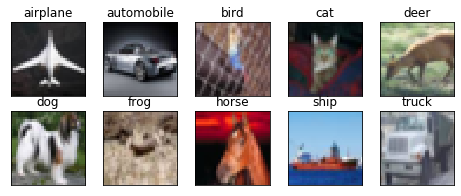

In [7]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils


from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))


class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()


def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()


def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)


train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

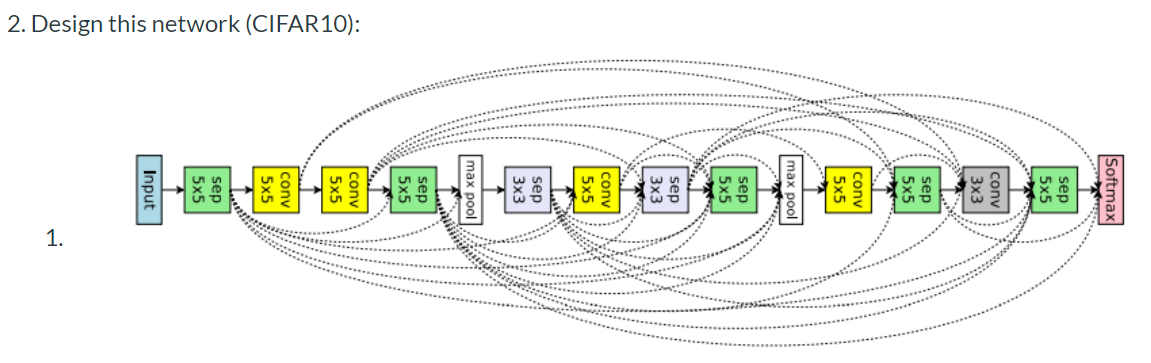

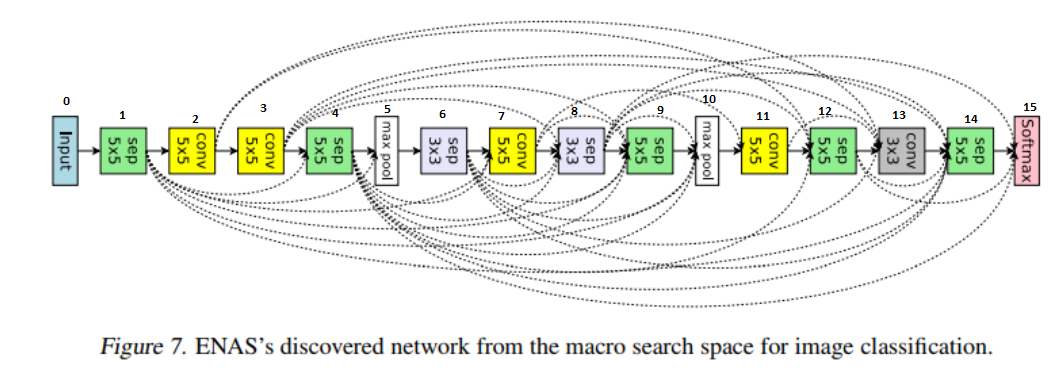

# Building ENAS network

In [3]:
from keras.layers import SeparableConv2D
import keras

# Define the model
model = Sequential()

#0. Input
initial_input = keras.Input(shape= (32, 32, 3))     # 32, 32, 3

#1. sep 5x5  #inputs = 1 -initial_input
x1_S_55  = SeparableConv2D(48, 5, 5, border_mode='same')(initial_input)      #32, 32, 48
x1_S_55 = BatchNormalization()(x1_S_55) #32, 32, 48
x1_S_55 = Activation('relu')(x1_S_55) #32, 32, 48

#2. conv 5x5  # inputs = 1 - x1_S_55
x2_C_55 = Convolution2D(48, 5, 5, border_mode = 'same')(x1_S_55) #32, 32, 48
x2_C_55 = BatchNormalization()(x2_C_55) #32, 32, 48
x2_C_55 = Activation('relu')(x2_C_55) #32, 32, 48

#3. conv 5x5  # inputs = 1 - x2_C_55
x3_C_55 = Convolution2D(48, 5, 5, border_mode = 'same')(x2_C_55) #32, 32, 48
x3_C_55 = BatchNormalization()(x3_C_55) #32, 32, 48
x3_C_55 = Activation('relu')(x3_C_55) #32, 32, 48

#4. sep 5x5 # inputs = 2 - x3_C_55, x3_C_55
concat1 =  keras.layers.concatenate([x3_C_55, x3_C_55]) #32, 32, 48
x4_S_55 = SeparableConv2D(48, 5, 5, border_mode = 'same')(concat1) #32, 32, 48
x4_S_55 = BatchNormalization()(x4_S_55)
x4_S_55 = Activation('relu')(x4_S_55)

#5. maxpool inputs = 2 - x4_S_55, x1_S_55
concat2 = keras.layers.concatenate([x4_S_55,x1_S_55 ]) #32, 32, 96
x5_M_22 = MaxPooling2D(pool_size = (2, 2)) (concat2) #16, 16, 96


#6. sep 3x3 inputs = 1 - x5_M_22
x6_S_33 = SeparableConv2D(96, 3, 3, border_mode = 'same' )(x5_M_22)    # 16, 16, 96
x6_S_33 = BatchNormalization()(x6_S_33) # 16, 16, 96
x6_S_33 = Activation('relu')(x6_S_33) # 16, 16, 96
x6_S_33_zero_pad1 = keras.layers.ZeroPadding2D(padding=(8,8))(x6_S_33)   #32, 32, 96

#7. conv 5x5 inputs = 3 - x6_S_33, x4_S_55, x1_S_55
concat3 = keras.layers.concatenate([x6_S_33_zero_pad1, x4_S_55, x1_S_55]) #32, 32, 96
x7_C_33 = Convolution2D(192, 5, 5,border_mode = 'same' )(concat3) #32, 32, 192
x7_C_33 = BatchNormalization()(x7_C_33) #32, 32, 192
x7_C_33 = Activation('relu')(x7_C_33) #32, 32, 192

#8. sep 3x3 inputs = 4 -  x7_C_33, x3_C_55, x4_S_55, x6_S_33_zero_pad1
concat4 = keras.layers.concatenate([x7_C_33, x3_C_55, x4_S_55, x6_S_33_zero_pad1])  #32, 32, 384
x8_S_33 = SeparableConv2D(384, 3, 3, border_mode='same')(concat4) #32, 32, 384
x8_S_33 = BatchNormalization()(x8_S_33) #32, 32, 384
x8_S_33 = Activation('relu')(x8_S_33) #32, 32, 384

#9. sep 5x5 inputs = 6 - top(3,7,8) bottom-(6,1,4) x8_S_33,  x7_C_33, x6_S_33_zero_pad1, x4_S_55, x3_C_55,  x1_S_55
x9_S_55 = SeparableConv2D(384, 5, 5, border_mode = 'same')(x8_S_33)  #32, 32, 384
x9_S_55 = BatchNormalization()(x9_S_55)  #32, 32, 384
x9_S_55 = Activation('relu')(x9_S_55)  #32, 32, 384

#10. maxpool inputs = 4 (8, 9, 6, 4, 1)  (x9_S_55, x8_S_33, x6_S_33_zero_pad1, x4_S_55,  x1_S_55)
concat5 = keras.layers.concatenate([x9_S_55, x8_S_33, x6_S_33_zero_pad1, x4_S_55,  x1_S_55])
x10_M_22 = MaxPooling2D(pool_size = (2, 2))(concat5)   #16, 16, 960
# If a layer receives skip connections from multiple layers before it, then
# these layers’ outputs are concatenated in their depth dimension, and then a convolution of filter size 1 × 1 (followed
# by a batch normalization layer and a ReLU layer)
x10_C_11 = Convolution2D(384, 1, 1, border_mode = 'same')(x10_M_22)   #16, 16, 384
x10_C_11 = BatchNormalization()(x10_C_11) #16, 16, 384
x10_C_11 = Activation('relu')(x10_C_11) #16, 16, 384
x10_C_11_zero_pad = keras.layers.ZeroPadding2D(padding=(8,8))(x10_C_11) #32, 32, 384

#11. conv 5x5  inputs = 2 (10, 7)  (x10_C_11_zero_pad, x7_C_33)
concat6 = keras.layers.concatenate([x10_C_11_zero_pad, x7_C_33])    #32, 32, 384
x11_C_55 = Convolution2D(576, 5, 5, border_mode = 'same')(concat6)  #32, 32, 384
x11_C_55 = BatchNormalization()(x11_C_55)  #32, 32, 384
x11_C_55 = Activation('relu')(x11_C_55)  #32, 32, 384

#12. sep 5x5 inputs = 4 (2, 8, 11, 4)  (x2_C_55, x8_S_33,  x11_C_55, x4_S_55 )
concat7 = keras.layers.concatenate([x2_C_55, x8_S_33,  x11_C_55, x4_S_55])
# If a layer receives skip connections from multiple layers before it, then
# these layers’ outputs are concatenated in their depth dimension, and then a convolution of filter size 1 × 1 (followed
# by a batch normalization layer and a ReLU layer)
x12_C_11 = Convolution2D(384, 1, 1, border_mode = 'same')(concat7)
x12_C_11 = BatchNormalization()(x12_C_11)
x12_C_11 = Activation('relu')(x12_C_11)
x12_S_55 = SeparableConv2D(384, 5, 5, border_mode = 'same')(x12_C_11)
x12_S_55 = BatchNormalization()(x12_S_55) 
x12_S_55 = Activation('relu')(x12_S_55)

#13. conv 3x3 inputs = 5  (2, 3, 11, 12, 6 ) (x2_C_55, x3_C_55, x11_C_55, x12_S_55,x6_S_33_zero_pad1 )
concat8 = keras.layers.concatenate([x2_C_55, x3_C_55, x11_C_55, x12_S_55,x6_S_33_zero_pad1 ])
# If a layer receives skip connections from multiple layers before it, then
# these layers’ outputs are concatenated in their depth dimension, and then a convolution of filter size 1 × 1 (followed
# by a batch normalization layer and a ReLU layer)
x13_C_11 = Convolution2D(384, 1, 1, border_mode = 'same')(concat8)
x13_C_11 = BatchNormalization()(x13_C_11)
x13_C_11 = Activation('relu')(x13_C_11)
x13_C_33 = Convolution2D(384, 3, 3, border_mode='same')(x13_C_11)
x13_C_33 = BatchNormalization()(x13_C_33)
x13_C_33 = Activation('relu')(x13_C_33)


# 14. sep 5x5 inputs = 7  (8, 3, 13, 12, 1, 4, 6)  (x8_S_33,x3_C_55, x13_C_33,x12_S_55,x1_S_55, x4_S_55, x6_S_33_zero_pad1  )
concat9 = keras.layers.concatenate([x8_S_33,x3_C_55, x13_C_33,x12_S_55,x1_S_55, x4_S_55, x6_S_33_zero_pad1])
# If a layer receives skip connections from multiple layers before it, then
# these layers’ outputs are concatenated in their depth dimension, and then a convolution of filter size 1 × 1 (followed
# by a batch normalization layer and a ReLU layer)
x14_C_11 = Convolution2D(384, 1, 1, border_mode='same')(concat9)
x14_C_11 = BatchNormalization()(x14_C_11)
x14_C_11 = Activation('relu')(x14_C_11)
x14_S_55 = SeparableConv2D(384, 5, 5, border_mode='same')(x14_C_11)
x14_S_55 = BatchNormalization()(x14_S_55)
x14_S_55 = Activation('relu')(x14_S_55)

# 15. Softmax inputs = 4 (8, 14, 12, 4) (x8_S_33, x14_S_55, x12_S_55, x4_S_55 )
concat10 = keras.layers.concatenate([x8_S_33, x14_S_55, x12_S_55, x4_S_55])
# If a layer receives skip connections from multiple layers before it, then
# these layers’ outputs are concatenated in their depth dimension, and then a convolution of filter size 1 × 1 (followed
# by a batch normalization layer and a ReLU layer)
x15_C_11 = Convolution2D(384, 1, 1)(concat10)
x15_C_11 = BatchNormalization()(x15_C_11)
x15_C_11 = Activation('relu')(x15_C_11)
x15_M_22 = MaxPooling2D(pool_size=(2,2))(x15_C_11)
x15_C_11 = Convolution2D(192, 1, 1)(x15_M_22)
x15_C_11 = BatchNormalization()(x15_C_11)
x15_C_11 = Activation('relu')(x15_C_11)
x15_M_22 = MaxPooling2D(pool_size=(2,2))(x15_C_11)
x15_C_11 = Convolution2D(96, 1, 1)(x15_M_22)
x15_C_11 = BatchNormalization()(x15_C_11)
x15_C_11 = Activation('relu')(x15_C_11)
x15_M_22 = MaxPooling2D(pool_size=(2,2))(x15_C_11)
x15_C_11 = Convolution2D(10, 3, 3, )(x15_M_22)
x15_C_11 = BatchNormalization()(x15_C_11)
x15_C_11 = Activation('relu')(x15_C_11)
x15_C_11 = Convolution2D(10, 2, 2)(x15_C_11)
x15_C_11 = BatchNormalization()(x15_C_11)
x15_C_11 = Activation('relu')(x15_C_11)
prediction = Flatten()(x15_C_11)


model = keras.Model(inputs = initial_input, outputs = prediction)
model.summary()





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(48, (5, 5), padding="same")`
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(48, (5, 5), padding="same")`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(96, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(384, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(384, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(384, (1, 1), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(576, 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 48)   267         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 48)   192         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 48)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

# Compiling the model

In [4]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training

In [0]:
#Training
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':




Epoch 1/100
390/390 [==============================] - 311s 798ms/step - loss: 4.3271 - acc: 0.2120 - val_loss: 5.7617 - val_acc: 0.1993
Epoch 2/100
390/390 [==============================] - 294s 754ms/step - loss: 2.6646 - acc: 0.2728 - val_loss: 2.4954 - val_acc: 0.2756
Epoch 3/100
390/390 [==============================] - 294s 754ms/step - loss: 2.7390 - acc: 0.2513 - val_loss: 3.0736 - val_acc: 0.2289
Epoch 4/100
390/390 [==============================] - 294s 754ms/step - loss: 2.5742 - acc: 0.2301 - val_loss: 2.4148 - val_acc: 0.2337
Epoch 5/100
390/390 [==============================] - 294s 754ms/step - loss: 2.3028 - acc: 0.2459 - val_loss: 2.7248 - val_acc: 0.2280
Epoch 6/100
390/390 [==============================] - 294s 754ms/step - loss: 2.4143 - acc: 0.2221 - val_loss: 2.5041 - val_acc: 0.2151
Epoch 7/100
390/390 [==============================] - 294s 754ms/step - loss: 3.1035 - acc: 0.1974 - val_loss: 5.4610 - val_acc: 0.1899
Epoch 8/100
390/390 [==================

KeyboardInterrupt: ignored

In [0]:
model.save_weights('assignment_7B_1.h5')

In [0]:
model.load_weights('assignment_7B_1.h5')

In [9]:
model.load_weights('assignment_7B_1.h5')
#Training
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 64),samples_per_epoch = train_features.shape[0], nb_epoch = 12,  validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=781, epochs=12)`
  if sys.path[0] == '':


Epoch 1/12
781/781 [==============================] - 1346s 2s/step - loss: 1.6435 - acc: 0.4513 - val_loss: 1.5367 - val_acc: 0.4594
Epoch 2/12
781/781 [==============================] - 1328s 2s/step - loss: 1.6059 - acc: 0.4626 - val_loss: 11.4556 - val_acc: 0.1038
Epoch 3/12
781/781 [==============================] - 1328s 2s/step - loss: 1.5974 - acc: 0.4541 - val_loss: 1.6198 - val_acc: 0.4616
Epoch 4/12
781/781 [==============================] - 1329s 2s/step - loss: 1.5519 - acc: 0.4725 - val_loss: 1.7349 - val_acc: 0.4101
Epoch 5/12
781/781 [==============================] - 1331s 2s/step - loss: 1.4834 - acc: 0.4904 - val_loss: 1.4575 - val_acc: 0.5029
Epoch 6/12
781/781 [==============================] - 1330s 2s/step - loss: 1.8127 - acc: 0.4075 - val_loss: 1.9185 - val_acc: 0.3692
Epoch 7/12
781/781 [==============================] - 1324s 2s/step - loss: 1.5929 - acc: 0.4409 - val_loss: 1.4898 - val_acc: 0.4878
Epoch 8/12
781/781 [==============================] - 1326s 2

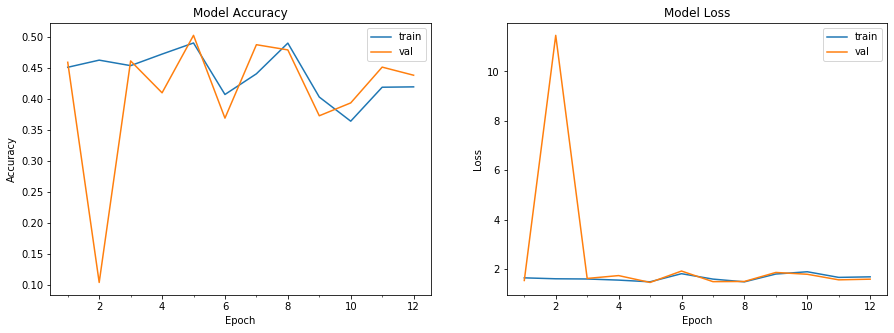

Accuracy on test data is: 43.85


In [10]:
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))